In [1]:
# https://medium.com/geekculture/time-series-analysis-using-arima-model-with-python-afe4b41bbec8
# https://pub.towardsai.net/electricity-production-forecasting-using-arima-model-in-python-d3bf38dc3517

import itertools
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import pandas_gbq
import seaborn as sns; sns.set()
import statsmodels.api as sm

from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"
TABLE_NAME = "res_tickers_history"

warnings.filterwarnings("ignore")

In [2]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

def test_p_value(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')

def stationarity_test(data):
    test_p_value(data['volume_weighted_average_price'])

def plot_history(data):
    plt.figure(figsize=(20, 10), dpi=150)
    plt.plot(data.date, data.volume_weighted_average_price, color='tab:blue')
    plt.gca().set(title=f'{data.name} Stock History', xlabel='Date', ylabel='$')
    plt.show()


def seasonal_decomposition(data):
    result_add = seasonal_decompose(data.volume_weighted_average_price, model='additive', extrapolate_trend='freq', period=365)
    plt.rcParams.update({'figure.figsize': (20, 20)})
    result_add.plot().suptitle('', fontsize=15)
    plt.show()


def arima_model_selector(data, pdq, seasonal_pdq):
    models = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    data.volume_weighted_average_price,
                    order=param, seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
                results = mod.fit(disp=False)
                models.append((param, param_seasonal, results.aic))
                print('SARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return models


def run_best_model(data, model, days):
    model = sm.tsa.statespace.SARIMAX(
        data.volume_weighted_average_price,
        order=best_model[0], seasonal_order=best_model[1],
        enforce_stationarity=False,
        enforce_invertibility=False)
    results = model.fit(disp=False)
    data['prediction'] = results.predict()
    data[['volume_weighted_average_price', 'prediction']].plot(figsize=(12,8))
    extra_dates = [data.set_index('date').index[-1] + DateOffset(days=d) for d in range (1, days)]
    forecast_df = pd.DataFrame(index=extra_dates, columns=data.columns)
    data = data.set_index(pd.DatetimeIndex(data['date']))
    combined_df = pd.concat([data, forecast_df]).reset_index()
    combined_df['prediction'] = results.predict(len(amazon), len(combined_df))
    combined_df[['date','volume_weighted_average_price','prediction']].plot(figsize=(12,6))
    return combined_df

In [3]:
apple = query_ticker_data('AAPL')
netflix = query_ticker_data('NFLX')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_history` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard")
fb = query_ticker_data('FB')
microsoft = query_ticker_data('MSFT')
amazon = query_ticker_data('AMZN')
alphabet = query_ticker_data('GOOGL')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"

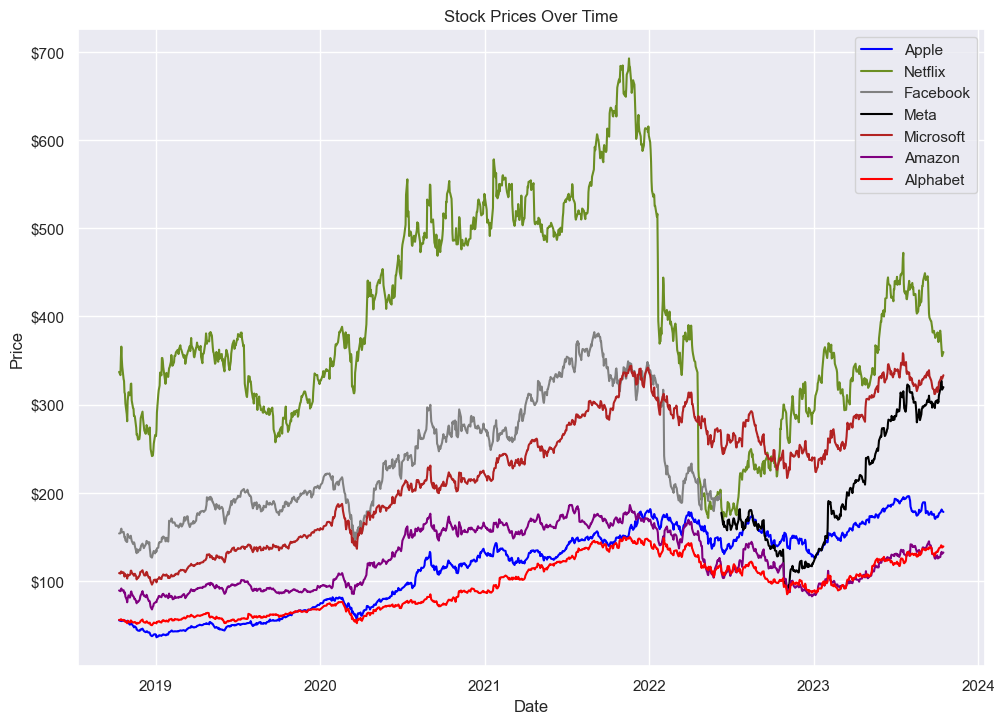

In [4]:
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

company = [apple, netflix, fb, meta, microsoft, amazon, alphabet]
color = ['blue', 'olivedrab', 'grey','black','firebrick','purple', 'red']    
for cmp, clr in zip(company,color):
    ax = sns.lineplot(data=cmp,x="date",y="volume_weighted_average_price",color=clr,label=cmp.name)
    ax.set(xlabel='Date',
       ylabel='Price',
       title='Stock Prices Over Time')
    ticks = ax.get_yticks()
    # formatted the values into strings beginning with dollar sign
    new_labels = [f'${int(amt)}' for amt in ticks]
    # Set the new labels
    ax.set_yticklabels(new_labels)    

plt.show()

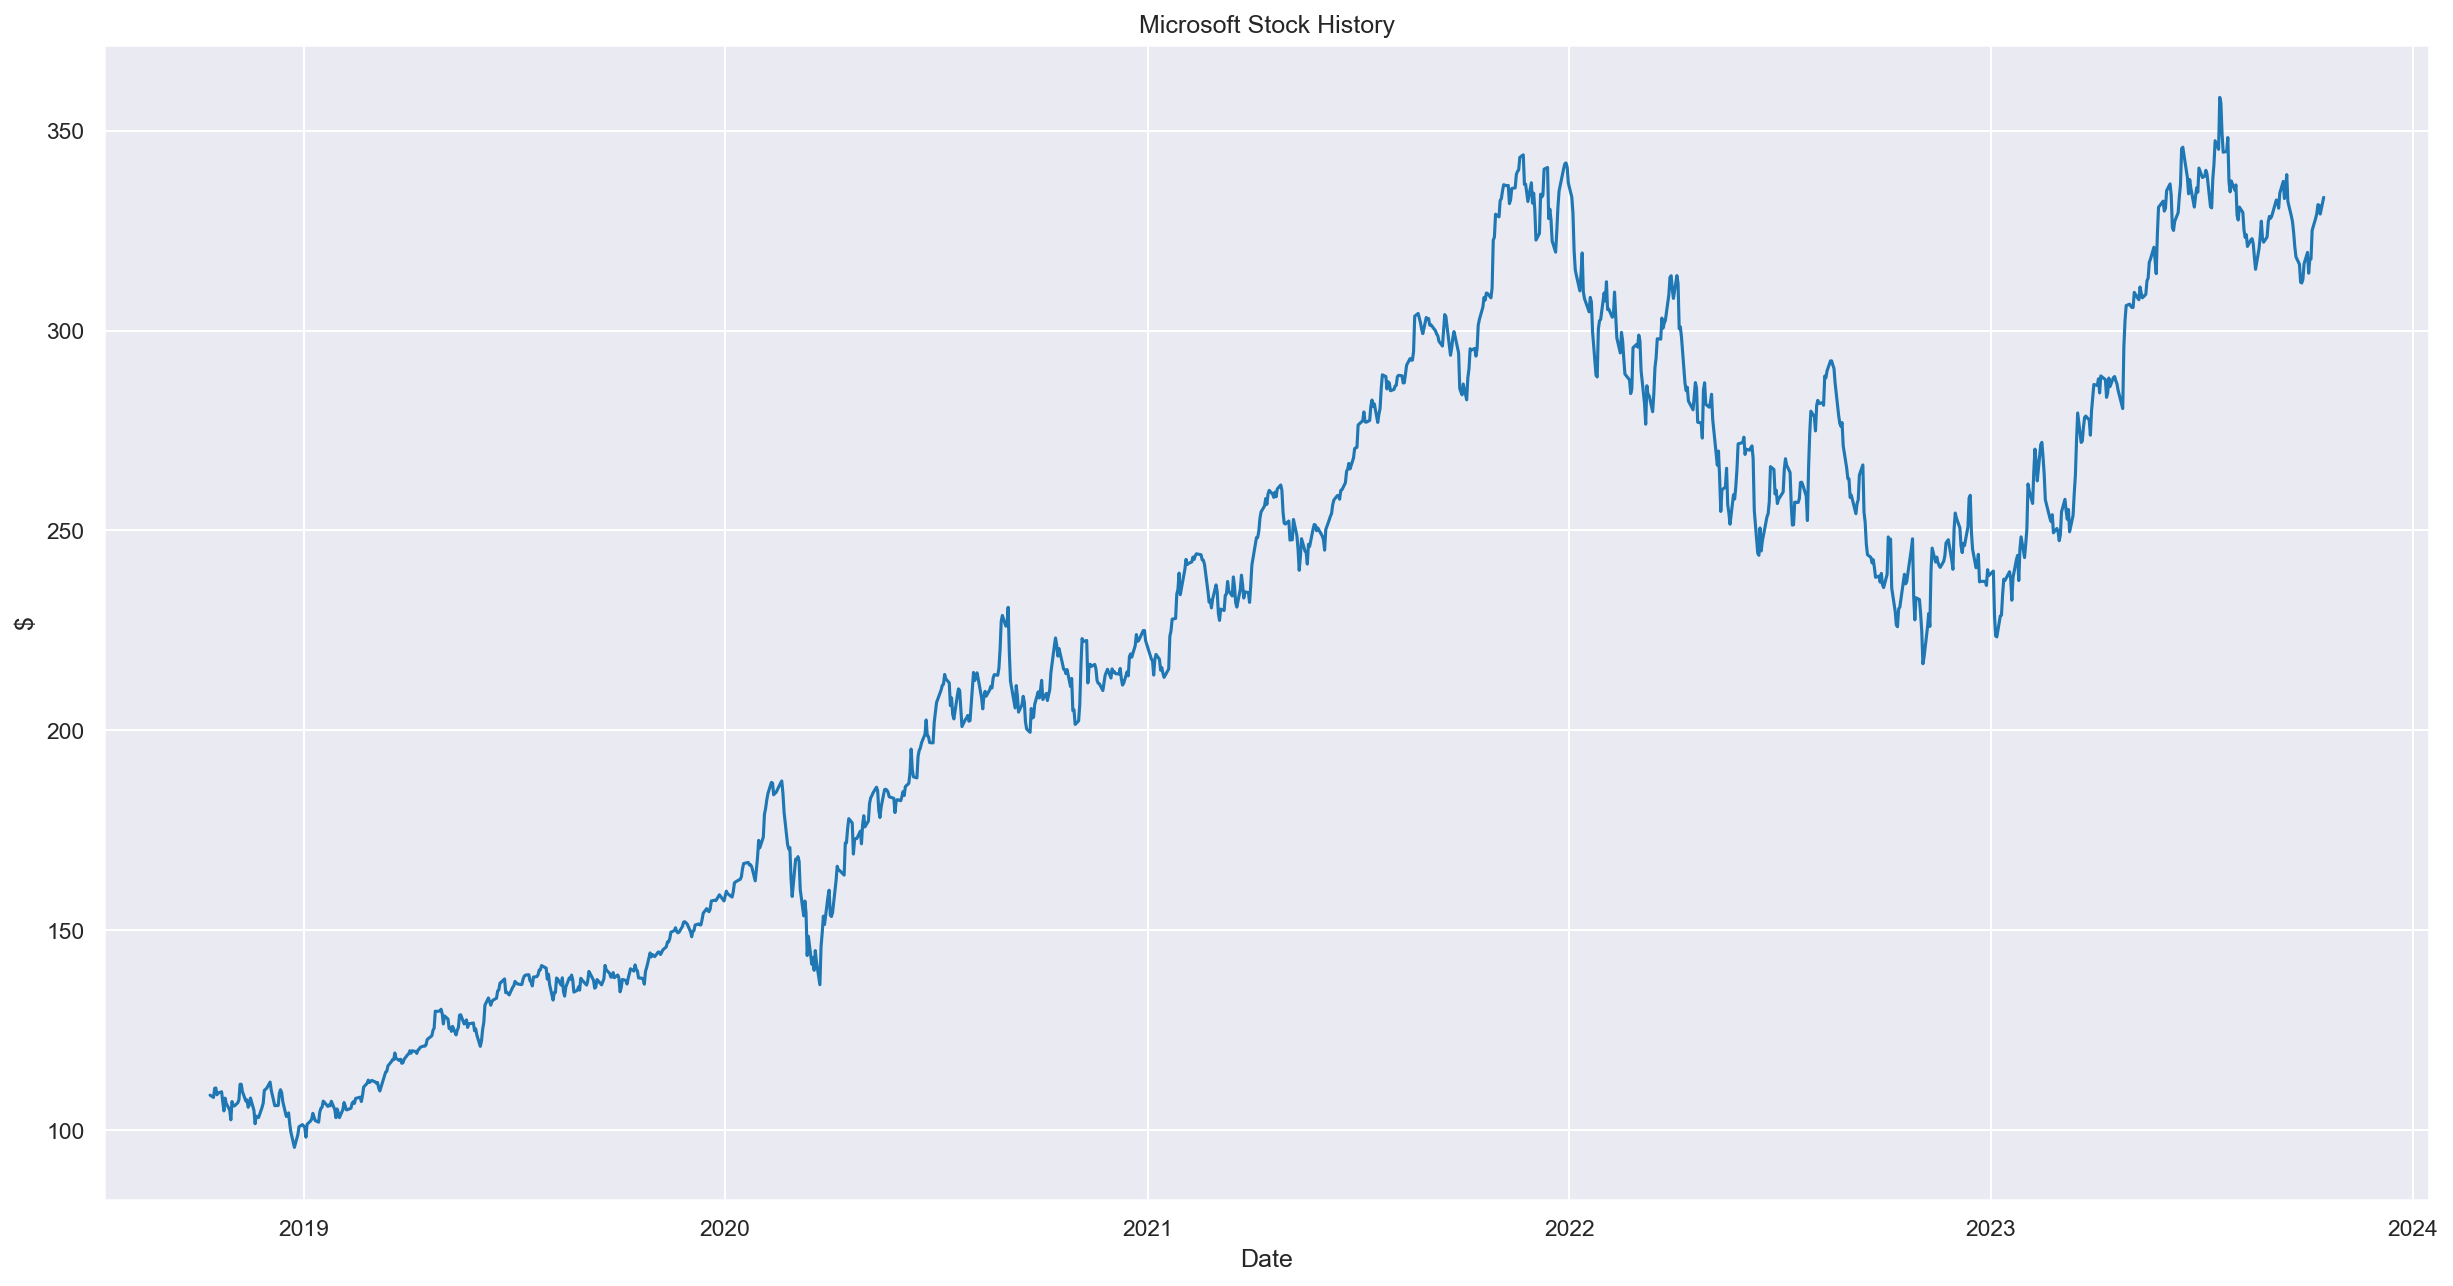

In [5]:
plot_history(microsoft)

In [6]:
stationarity_test(microsoft)

P-value:  0.7431664501035498
Do not reject null hypothesis, data is not stationary


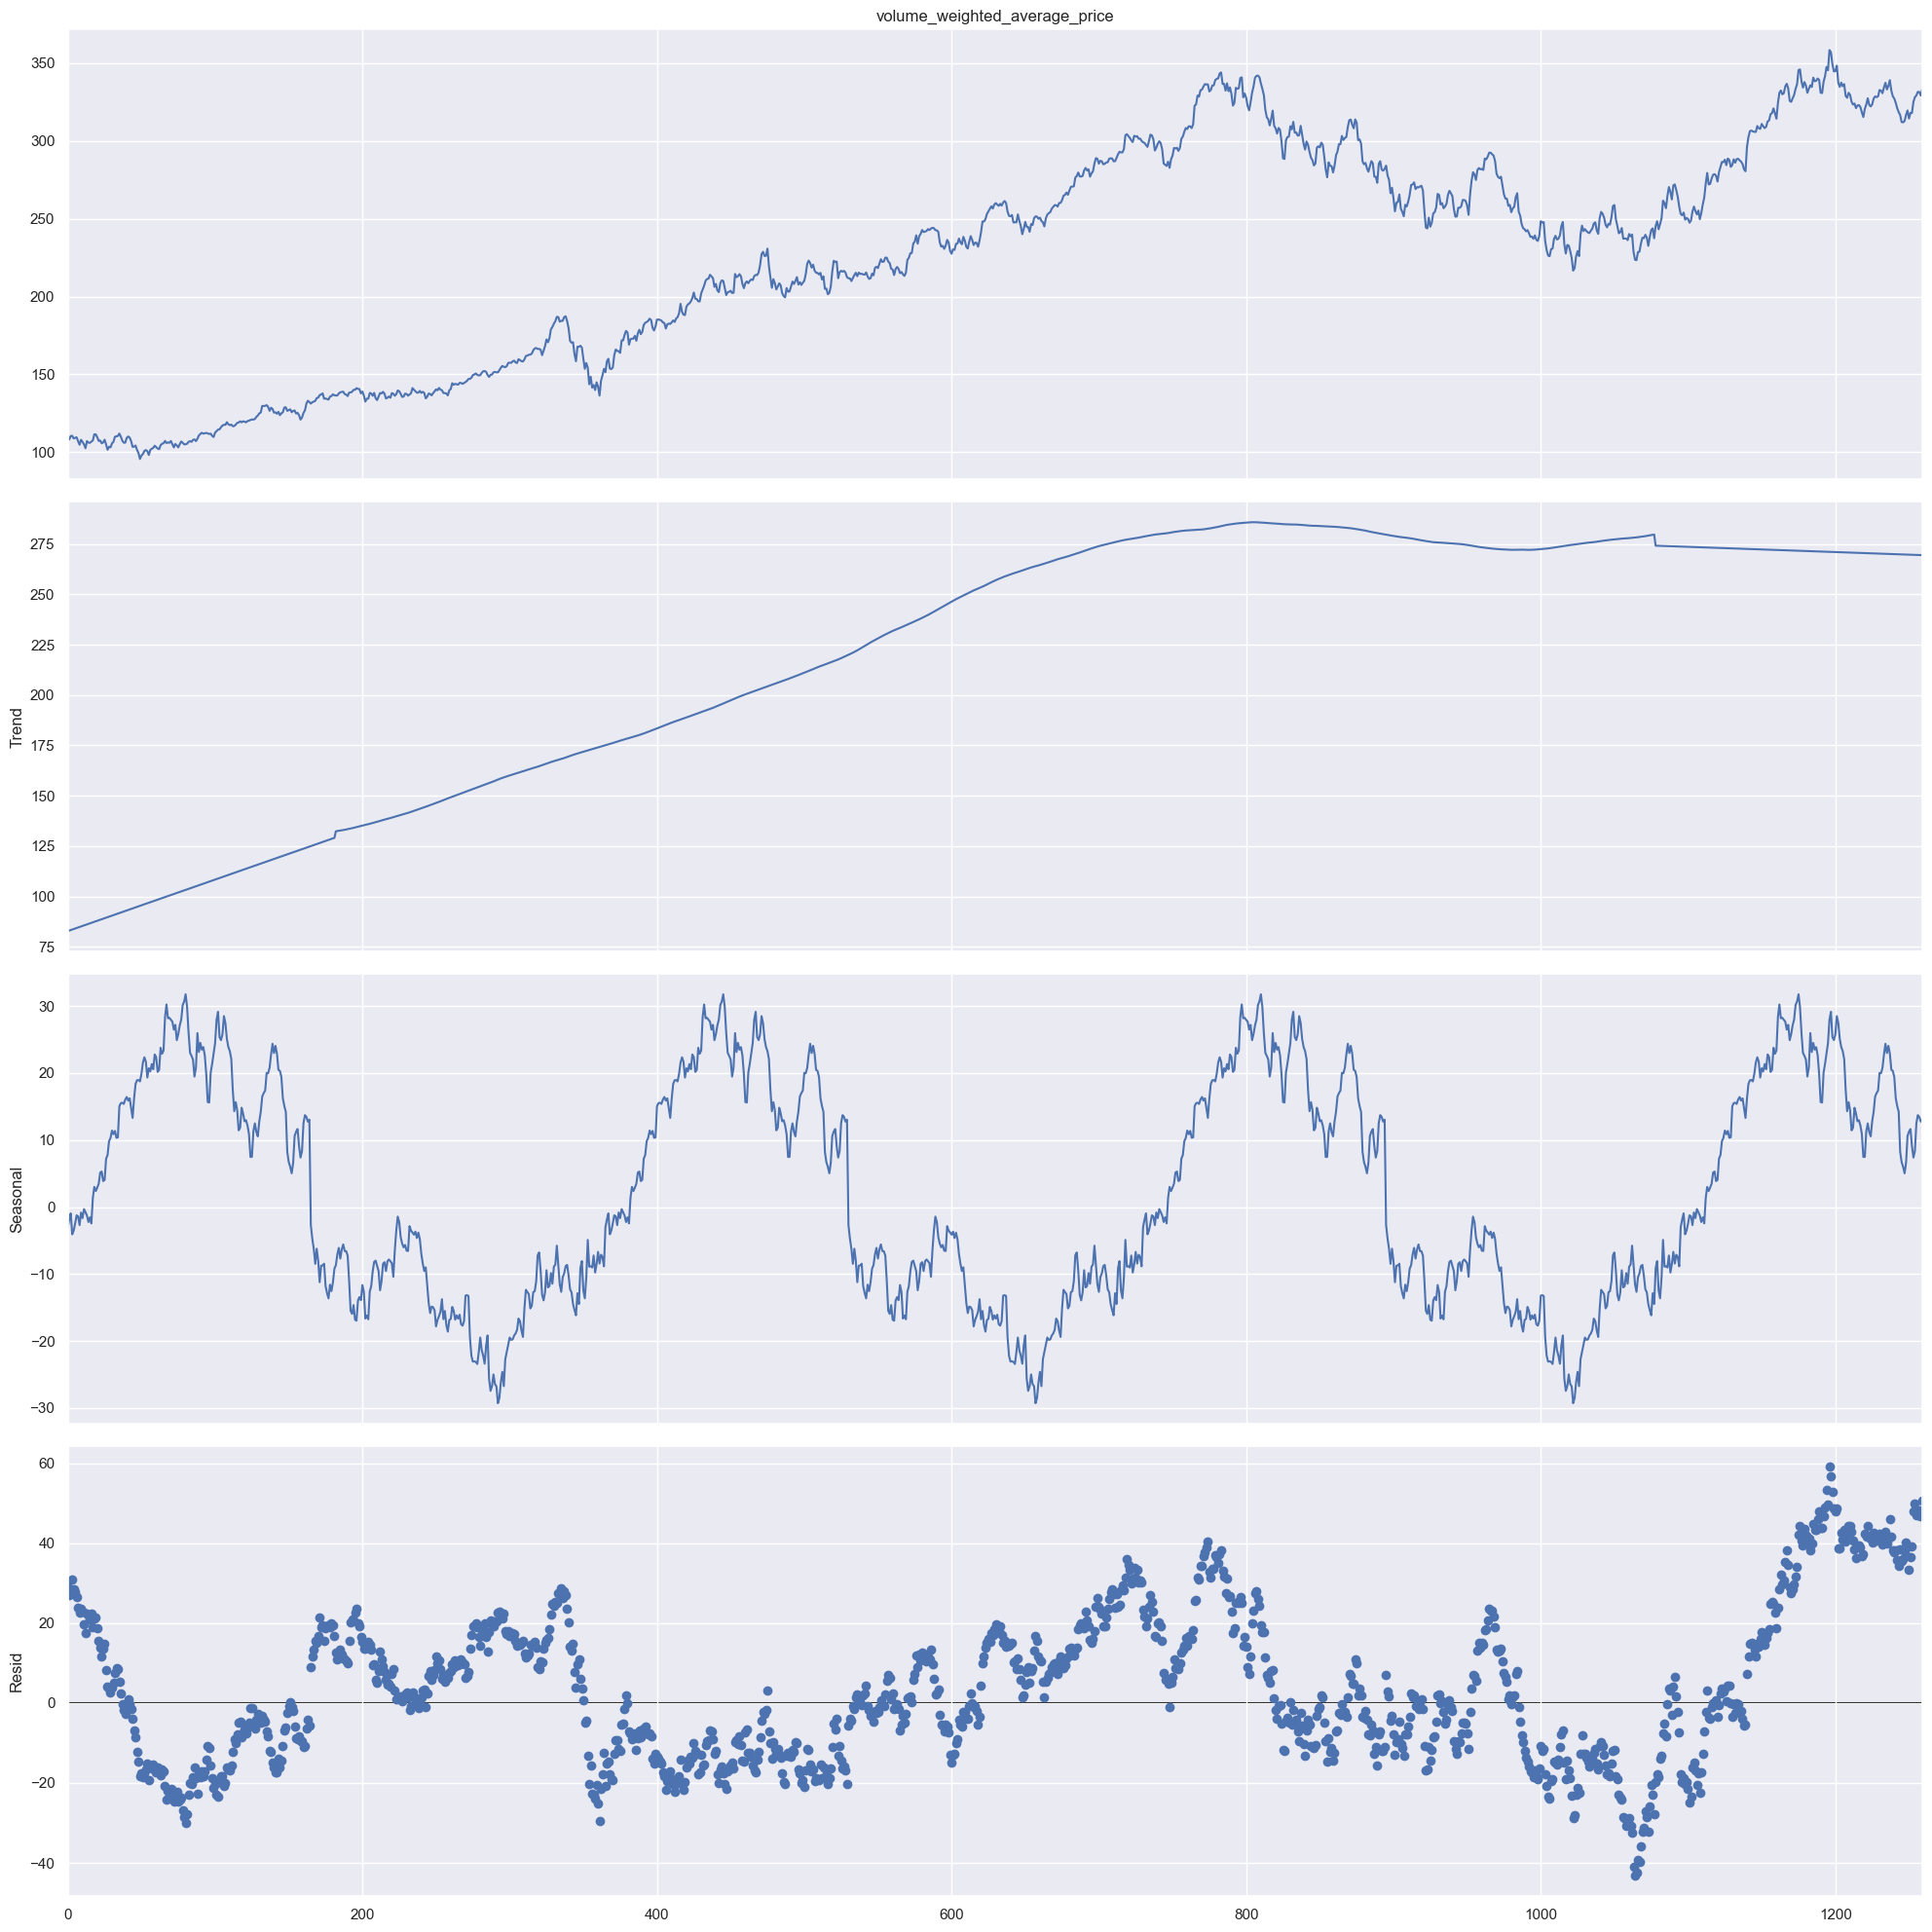

In [7]:
seasonal_decomposition(microsoft)

In [8]:
p = d = q = range(0, 2)
#generate patterns from p,q,r
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [9]:
models = arima_model_selector(microsoft, pdq, seasonal_pdq)

SARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC:17339.994968195773
SARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC:15577.200719048957
SARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC:9865.447791135246
SARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC:9781.012561958216
SARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC:9855.067407756787
SARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC:9842.983458620496
SARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC:9788.251965734362
SARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC:9782.900423181512
SARIMA(0, 0, 1)*(0, 0, 0, 12)12 - AIC:15606.023062386015
SARIMA(0, 0, 1)*(0, 0, 1, 12)12 - AIC:13887.794224633553
SARIMA(0, 0, 1)*(0, 1, 0, 12)12 - AIC:8647.905274390578
SARIMA(0, 0, 1)*(0, 1, 1, 12)12 - AIC:8552.605353780662
SARIMA(0, 0, 1)*(1, 0, 0, 12)12 - AIC:8649.763670604294
SARIMA(0, 0, 1)*(1, 0, 1, 12)12 - AIC:8658.464912128427
SARIMA(0, 0, 1)*(1, 1, 0, 12)12 - AIC:8567.026506762008
SARIMA(0, 0, 1)*(1, 1, 1, 12)12 - AIC:8553.934781509852
SARIMA(0, 1, 0)*(0, 0, 0, 12)12 - AIC:6757.596951576278
SARIMA(0, 1, 0)*(0, 0, 1, 12)12 - AIC:6702.0

In [10]:
model_params = pd.DataFrame(models, columns=["param", "param_seasonal", "aic"])

In [11]:
best_model = model_params[model_params['aic']==model_params['aic'].min()].values.tolist()[0]

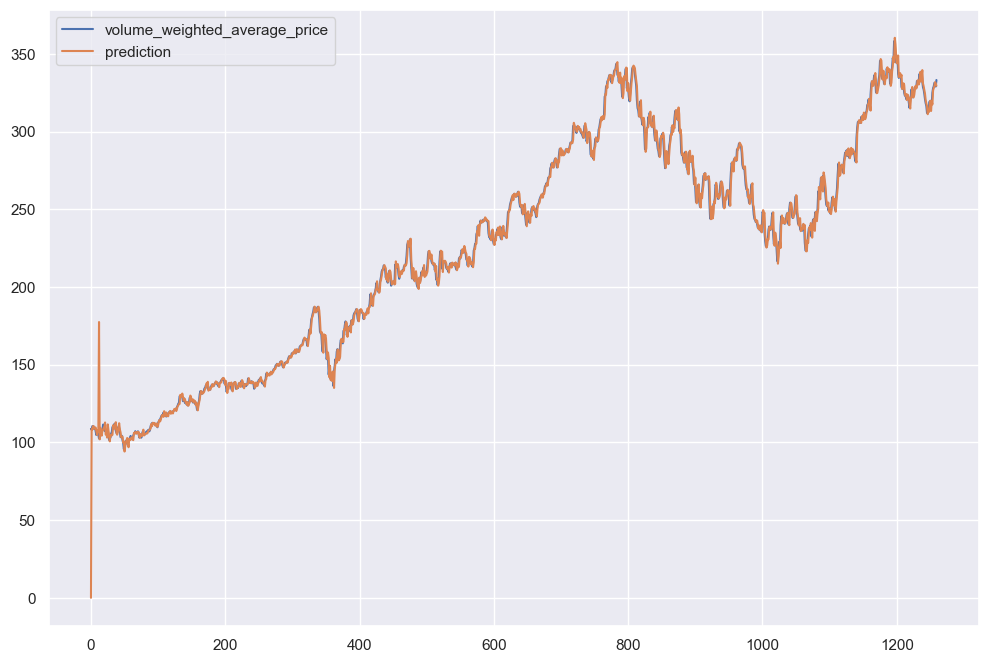

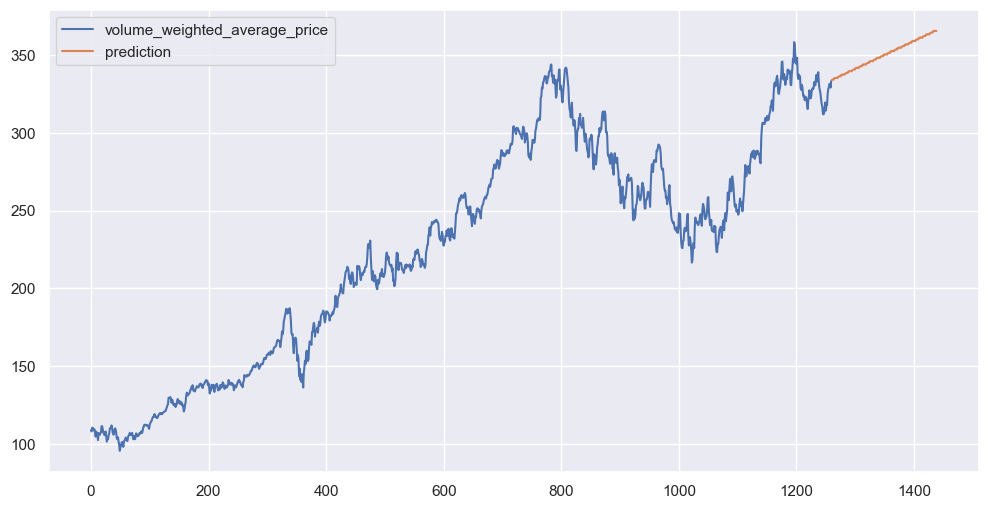

In [12]:
y = run_best_model(microsoft, best_model, 180)